## Triple Orbit Nb


In [12]:
%matplotlib inline

import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

In [25]:
class TripleOrbit():
    """
    TripleOrbit class implements the parameters and differential equation for 
     three-body gravitational motion using the notation above.
     
    Parameters
    ----------
    m1 : float
        first bob's mass 
    m2 : float
        second bob's mass
    m3 : float
        third bob's mass
    g : float
        value of gravitational constant 

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, m1=1., m2=1., m3=1., G=1.):
        self.m1=m1
        self.m2=m2
        self.m3=m3
        self.G=G
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with 
            y[0] = x_1(t) = x1
            y[1] = y_1(t) = y1
            y[2] = x_2(t) = x2
            y[3] = y_2(t) = y2
            y[4] = x_3(t) = x3
            y[5] = y_3(t) = y3
            
            y[6] = dx_1/dt(t)
            y[7] = dy_1/dt(t)
            y[8] = dx_2/dt(t)
            y[9] = dy_2/dt(t)
            y[10] = dx_3/dt(t)
            y[11] = dy_3/dt(t)
            
        Returns
        -------
        y_dot: float
            A 4-component vector with 
            y_dot[0] = dx_1/dt(t) = y[6]
            y_dot[1] = dy_1/dt(t) = y[7]
            y_dot[2] = dx_2/dt(t) = y[8]
            y_dot[3] = dy_2/dt(t) = y[9]
            y_dot[4] = dx_3/dt(t) = y[10]
            y_dot[5] = dy_3/dt(t) = y[11]            
            
            y_dot[6] = d^2 x_1/dt^2(t)
            y_dot[7] = d^2 y_1/dt^2(t)
            y_dot[8] = d^2 x_2/dt^2(t)
            y_dot[9] = d^2 y_2/dt^2(t) 
            y_dot[10] = d^2 x_3/dt^2(t)
            y_dot[11] = d^2 y_3/dt^2(t)        
        """
        # Initialize return vector
        y_dot = np.zeros((12))
        # Define position vals 
        x1, y1, x2, y2, x3, y3 = y[0:6]
        # Grab constants
        G = self.G
        m1 = self.m1
        m2 = self.m2
        m3 = self.m3
        # Define useful calculated values
        x21, y21 = x2 - x1, y2 - y1
        x32, y32 = x3 - x2, y3 - y2
        x31, y31 = x3 - x1, y3 - y1
        denom21 = ((x21**2)+(y21**2))**(3./2.)
        denom32 = ((x32**2)+(y32**2))**(3./2.)
        denom31 = ((x31**2)+(y31**2))**(3./2.)
        
        # Do dx_i/dt first:
        y_dot[0:6] = y[6:12]
        
        # Now do d^2 x_i/dt^2(t) 
        y_dot[6]= G*(m2*x21/denom21 + m3*x31/denom31)
        y_dot[8]= G*(-m1*x21/denom21 + m3*x32/denom32)            
        y_dot[10]= G*(-m2*x31/denom31 - m3*x32/denom32)
        
        # Finally do d^2 y_i/dt^2(t) 
        y_dot[7]= G*(m2*y21/denom21 + m3*y31/denom31)
        y_dot[9]= G*(-m1*y21/denom21 + m3*y32/denom32)
        y_dot[11]= G*(-m2*y31/denom31 - m3*y32/denom32)
        return y_dot
    
    
    def solve_ode(self, t_pts, y_0, 
                  abserr=1.0e-8, relerr=1.0e-6):
        """
        Solve the ODE given initial conditions.
        For now use odeint, but we have the option to switch.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [y_0[i] for i in range(len(y_0))] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        return solution.y
    
    def solve_ode_Leapfrog(self, t_pts, y_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for r, rdot, r_dot_half, phi with zeros
        num_t_pts = len(t_pts)
        # Hold x1, y1, x2, y2, x3, y3 = q
        q = np.zeros((6, num_t_pts))
        # Hold x1_dot, y1_dot, x2_dot, y2_dot, x3_dot, y3_dot = q_dot
        q_dot = np.zeros((6, num_t_pts))
        # Hold x1_dot_half, y1_dot_half, x2_dot_half, y2_dot_half, 
        # x3_dot_half, y3_dot_half = q_dot_half
        q_dot_half = np.zeros((6, num_t_pts)) 
        
        # initial conditions
        q[:,0] = y_0[0:6]
        q_dot[:,0] = y_0[6:12]
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            # Initialize the y-vec to find derivatives
            y = np.zeros((12))
            y[0:6] = q[:,i]
            y[6:12] = q_dot[:,i]
            # Calculate q_dot_half
            q_dot_half[:,i] = q_dot[:,i] + self.dy_dt(t, y)[6:12]*delta_t/2.
            # Calculate q(i+1)
            q[:,i+1] = q[:,i] + q_dot_half[:,i] * delta_t
            # Fill the y-vec again to find derivatives with q[i+1]
            y[0:6] = q[:,i+1]
            y[6:12] = q_dot[:,i]
            # Calculate q_dot
            q_dot[:,i+1] = q_dot_half[:,i] + self.dy_dt(t, y)[6:12] \
                         * delta_t/2.
        # Create return vector    
        y_ret = np.zeros((12, num_t_pts))
        y_ret[:6,:] = q
        y_ret[6:,:] = q_dot    
        return y_ret

    
class DoubleOrbit():
    """
    DoubleOrbit class implements the parameters and differential equation 
    for two-body gravitational motion using the notation above.
     
    Parameters
    ----------
    m1 : float
        first bob's mass 
    m2 : float
        second bob's mass
    g : float
        value of gravitational constant 

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, m1=1., m2=1., m3=1., G=1.):
        self.m1=m1
        self.m2=m2
        self.m3=m3
        self.G=G
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with 
            y[0] = x_1(t)    = x1
            y[1] = y_1(t)    = y1
            y[2] = x_2(t)    = x2
            y[3] = y_2(t)    = y2
            y[4] = dx_1/dt(t)= u1
            y[5] = dy_1/dt(t)= v1
            y[6] = dx_2/dt(t)= u2
            y[7] = dy_2/dt(t)= v2
            
        Returns
        -------
        y_dot: float
            A 4-component vector with 
            y_dot[0] = dx_1/dt(t)= u1
            y_dot[1] = dy_1/dt(t)= v1
            y_dot[2] = dx_2/dt(t)= u2
            y_dot[3] = dy_2/dt(t)= v2  
            y_dot[4] = d^2 x_1/dt^2(t)
            y_dot[5] = d^2 y_1/dt^2(t)
            y_dot[6] = d^2 x_2/dt^2(t)
            y_dot[7] = d^2 y_2/dt^2(t) 
        
        """
        y_dot = [0. for i in range(8)]
        x1, y1, x2, y2, u1, v1, u2, v2 = y
        
        G = self.G
        m1 = self.m1
        m2 = self.m2

        x21 = x2-x1
        y21 = y2-y1
        
        denom = ((x21**2)+(y21**2))**(3./2.)
        
        # Do dphi_1/dt and dphi_2/dt first:
        y_dot[0:4] = y[4:8]
        
        # Now do d^2 x_{1,2}/dt^2(t) 
        y_dot[4]= G*m2*x21/denom
        y_dot[6]= -G*m1*x21/denom            
            
        # Finally do d^2 y_{1,2}/dt^2(t) 
        y_dot[5]= G*m2*y21/denom
        y_dot[7]= -G*m1*y21/denom
        
        return y_dot
    
    
    def solve_ode(self, t_pts, y_0, 
                  abserr=1.0e-8, relerr=1.0e-6):
        """
        Solve the ODE given initial conditions.
        For now use odeint, but we have the option to switch.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [y_0[i] for i in range(len(y_0))] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        return solution.y
    
    def solve_ode_Leapfrog(self, t_pts, y_0):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for r, rdot, r_dot_half, phi with zeros
        num_t_pts = len(t_pts)
        x1, x2, x1_dot, x2_dot = [np.zeros(num_t_pts) for i in range(4)]
        y1, y2, y1_dot, y2_dot = [np.zeros(num_t_pts) for i in range(4)]
        
        x1_dot_half, x2_dot_half, y1_dot_half, y2_dot_half = [ \
            np.zeros(num_t_pts) for i in range(4)]
        
        # initial conditions
        x1[0],y1[0],x2[0],y2[0] = y_0[0:4]
        x1_dot[0],y1_dot[0],x2_dot[0],y2_dot[0] = y_0[4:8]
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            y = [x1[i], y1[i], x2[i], y2[i], x1_dot[i], y1_dot[i], \
                 x2_dot[i], y2_dot[i]]
            x1_dot_half[i] = x1_dot[i] + self.dy_dt(t, y)[4]*delta_t/2.
            y1_dot_half[i] = y1_dot[i] + self.dy_dt(t, y)[5]*delta_t/2.
            x2_dot_half[i] = x2_dot[i] + self.dy_dt(t, y)[6]*delta_t/2.
            y2_dot_half[i] = y2_dot[i] + self.dy_dt(t, y)[7]*delta_t/2.
            
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            y1[i+1] = y1[i] + y1_dot_half[i] * delta_t
            x2[i+1] = x2[i] + x2_dot_half[i] * delta_t
            y2[i+1] = y2[i] + y2_dot_half[i] * delta_t
            
            y = [x1[i+1], y1[i+1], x2[i+1], y2[i+1], x1_dot[i], y1_dot[i],\
                 x2_dot[i], y2_dot[i]]
            
            x1_dot[i+1] = x1_dot_half[i] + self.dy_dt(t, y)[4] * delta_t/2.
            y1_dot[i+1] = y1_dot_half[i] + self.dy_dt(t, y)[5] * delta_t/2.
            x2_dot[i+1] = x2_dot_half[i] + self.dy_dt(t, y)[6] * delta_t/2.
            y2_dot[i+1] = y2_dot_half[i] + self.dy_dt(t, y)[7] * delta_t/2.
            
        return x1, y1, x2, y2, x1_dot, y1_dot, x2_dot, y2_dot

    
def StationaryIC2(orbit, sep, Ltot):
    # For Double Orbit
    # Finds ICs such that they start on the x-axis with seperation sep
    # and total angular momentum Ltot. Done using momentum conservation
    # Grab the masses
    m1 = orbit.m1
    m2 = orbit.m2
    
    # Calculate x1_0 and x2_0. Note x1_0 always negative
    x1_0 = -m2 * sep / (m1 + m2)
    x2_0 = m1 * sep / (m1 + m2)
    
    # Calculate y1_dot_0 and y2_dot_0. Note y1_dot_0 always negative
    # This calculation was done seperately by forcing p_x_tot=p_y_tot=0
    y1_dot_0 = Ltot/(m1*(x1_0-x2_0))
    y2_dot_0 = -Ltot/(m2*(x1_0-x2_0))
    
    # The rest of the I.C.s are held to zero
    IC = np.zeros((8))
    IC[0], IC[2] = x1_0, x2_0
    IC[5], IC[7] = y1_dot_0, y2_dot_0
    
    return IC    

In [22]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

# Labels for individual plot axes
x_vs_y_labels = (r'$x$', r'$y$')
deltax_vs_deltay = (r'$\dot x$', r'$\dot y$')

## 2-Body Orbit

In [17]:
# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Common pendulum parameters
m_1 = 15
m_2 = 5.
G_val = 1.


# Instantiate a pendulum 
do1 = DoubleOrbit(m1=m_1, m2 = m_2, G=G_val)

# Calculate Initial Conditions
seperation = 2
Ltot = 10

IC = StationaryIC2(orbit=do1, sep=seperation, Ltot=Ltot)
# Print order is:
# x1_0, y1_0, x2_0, y2_0, x1_dot_0, y1_dot_0, x2_dot_0, y2_dot_0
print(IC)

[-0.5         0.          1.5         0.          0.         -0.33333333
  0.          1.        ]


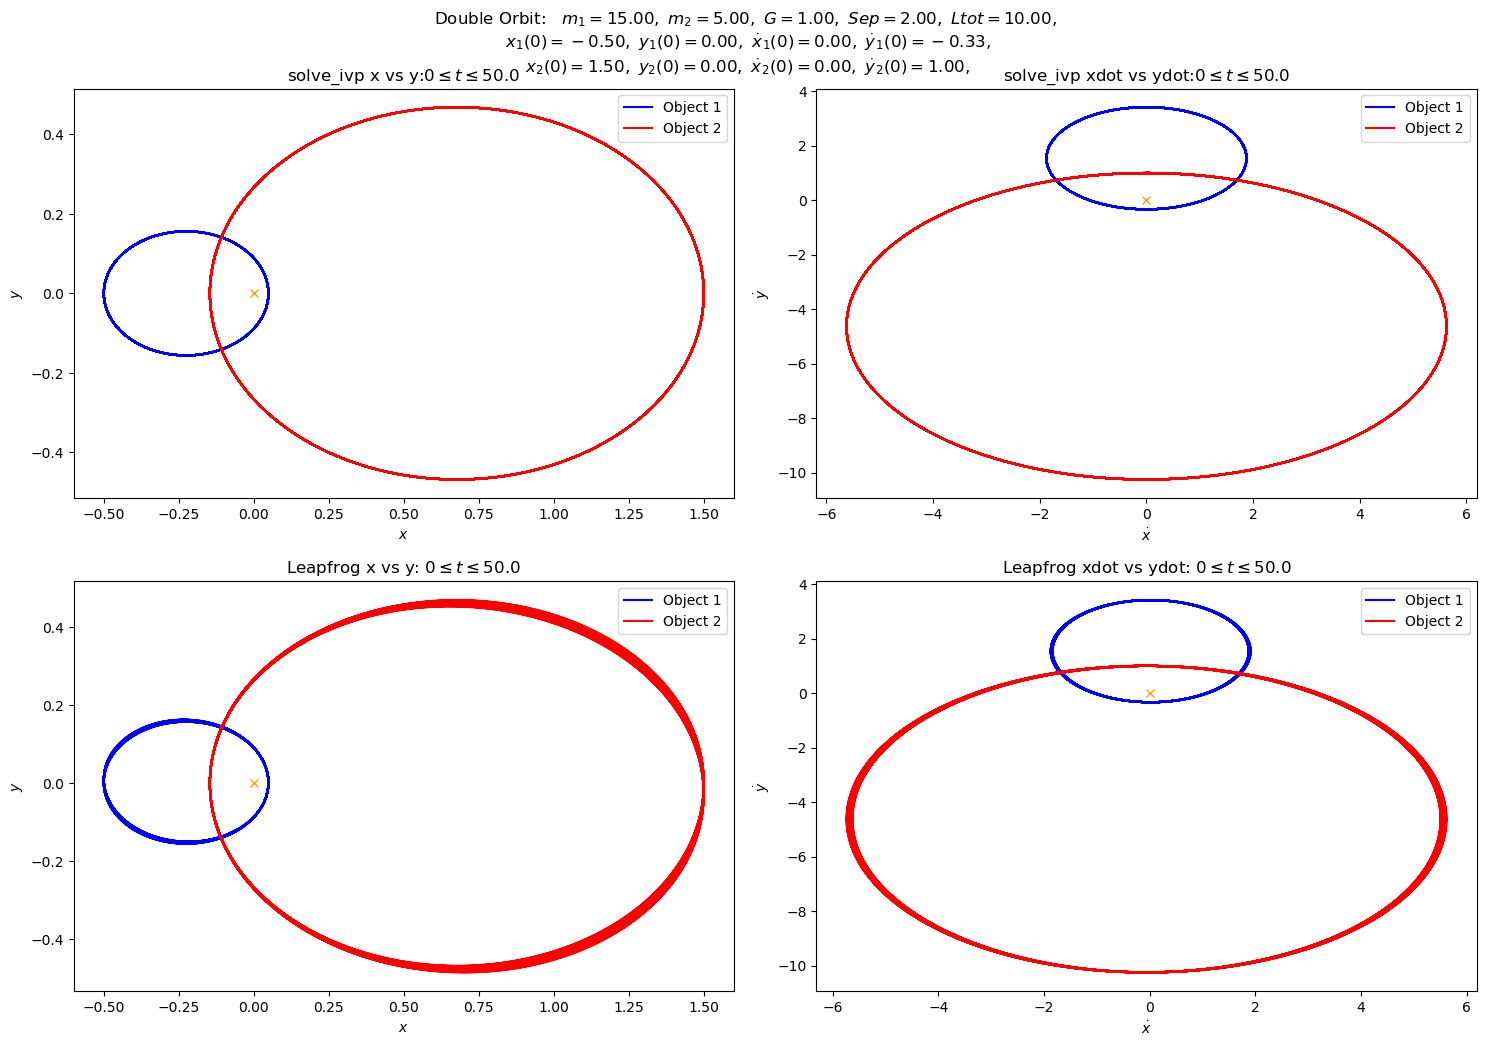

In [18]:
# Can use IC or type by hand
x1_0, y1_0 = IC[0:2] #-1., 0.
x2_0, y2_0 = IC[2:4] #1., 0.
x1_dot_0, y1_dot_0 = IC[4:6] #0., -1.5
x2_dot_0, y2_dot_0 = IC[6:8] #0., 1.5

y_0 =[x1_0, y1_0, x2_0, y2_0, x1_dot_0, y1_dot_0, x2_dot_0, y2_dot_0]

x1, y1, x2, y2, x1_dot, y1_dot, x2_dot, y2_dot = do1.solve_ode(t_pts, y_0)
x1_2, y1_2, x2_2, y2_2, x1_dot_2, y1_dot_2, x2_dot_2, y2_dot_2 = do1.solve_ode_Leapfrog(t_pts, y_0)

# start the plot!
fig = plt.figure(figsize=(15,10))

overall_title = 'Double Orbit:  ' + \
                rf' $m_1 = {m_1:.2f},$' + \
                rf' $m_2 = {m_2:.2f},$' + \
                rf' $G = {G_val:.2f},$' + \
                rf' $Sep = {seperation:.2f},$' + \
                rf' $Ltot = {Ltot:.2f},$' + '\n' + \
                rf' $x_1(0) = {x1_0:.2f},$' + \
                rf' $y_1(0) = {y1_0:.2f},$' + \
                rf' $\dot x_1(0) = {x1_dot_0:.2f},$'+ \
                rf' $\dot y_1(0) = {y1_dot_0:.2f},$' + '\n' \
                rf' $x_2(0) = {x2_0:.2f},$' + \
                rf' $y_2(0) = {y2_0:.2f},$' + \
                rf' $\dot x_2(0) = {x2_dot_0:.2f},$' + \
                rf' $\dot y_2(0) = {y2_dot_0:.2f},$'
fig.suptitle(overall_title, va='baseline')

# first plot position: plot from t=0 to t=10   
ax_a = fig.add_subplot(2,2,1)

# Add an 'x' at the CM of two objects (if using CalcStationaryIC)
ax_a.plot([0], [0], 'x', c='orange')

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x1[start : stop], y1[start : stop], 
            color='blue',
            label="Object 1",
            ax=ax_a)  
plot_y_vs_x(x2[start : stop], y2[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='red',
            label="Object 2", 
            title=rf'solve_ivp x vs y:$0 \leq t \leq {t_end:.1f}$', 
            ax=ax_a)  

# second plot: state space plot from t=30 to t=50   
ax_b = fig.add_subplot(2,2,2)                  
ax_b.plot([0], [0], 'x', c='orange')
start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x1_dot[start : stop], y1_dot[start : stop], 
            color='blue',
            label="Object 1",
            ax=ax_b)  
plot_y_vs_x(x2_dot[start : stop], y2_dot[start : stop], 
            axis_labels=deltax_vs_deltay, 
            color='red',
            label="Object 2", 
            title=rf'solve_ivp xdot vs ydot:$0 \leq t \leq {t_end:.1f}$', 
            ax=ax_b)  


# first plot position: plot from t=0 to t=10   
ax_a = fig.add_subplot(2,2,3)                  
ax_a.plot([0], [0], 'x', c='orange')
start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x1_2[start : stop], y1_2[start : stop], 
            color='blue',
            label="Object 1",
            ax=ax_a)  
plot_y_vs_x(x2_2[start : stop], y2_2[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='red',
            label="Object 2", 
            title=rf'Leapfrog x vs y: $0 \leq t \leq {t_end:.1f}$', 
            ax=ax_a)  

# second plot: state space plot from t=30 to t=50   
ax_b = fig.add_subplot(2,2,4)                  
ax_b.plot([0], [0], 'x', c='orange')
start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x1_dot_2[start : stop], y1_dot_2[start : stop], 
            color='blue',
            label="Object 1",
            ax=ax_b)  
plot_y_vs_x(x2_dot_2[start : stop], y2_dot_2[start : stop], 
            axis_labels=deltax_vs_deltay, 
            color='red',
            label="Object 2", 
            title=rf'Leapfrog xdot vs ydot: $0 \leq t \leq {t_end:.1f}$', 
            ax=ax_b)

fig.tight_layout()
fig.savefig('DoubleOrbit.png', bbox_inches='tight')  # always bbox_inches='tight'

## 3-Body Orbit

In [72]:
def StationaryIC2general(orbit, x1_dot_0, y1_dot_0, x2_dot_0, y2_dot_0):
    # Calculates the velocity of obj 3 to keep system momentum = 0
    m1 = orbit.m1
    m2 = orbit.m2
    m3 = orbit.m3
    x3_dot_0 = -(m1/m3)*x1_dot_0 - (m2/m3)*x2_dot_0
    y3_dot_0 = -(m1/m3)*y1_dot_0 - (m2/m3)*y2_dot_0
    return x3_dot_0, y3_dot_0

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Common pendulum parameters
m_1 = 10.
m_2 = 10.
m_3 = 10.
G_val = 2.


# Instantiate a pendulum 
to1 = TripleOrbit(m1 = m_1, m2 = m_2, m3 = m_3, G = G_val)

# Calculate Initial Conditions with arbitrary positions/velocities
x1_0, y1_0 = 0, 5.
x2_0, y2_0 = -5.*np.sqrt(3.)/2., -5/2
x3_0, y3_0 = 5.*np.sqrt(3.)/2., -5/2
x1_dot_0, y1_dot_0 = -1., 0.
x2_dot_0, y2_dot_0 = 0.5, -np.sqrt(3.)/2.
x3_dot_0, y3_dot_0 = StationaryIC2general(to1, x1_dot_0, y1_dot_0, \
                                          x2_dot_0, y2_dot_0)

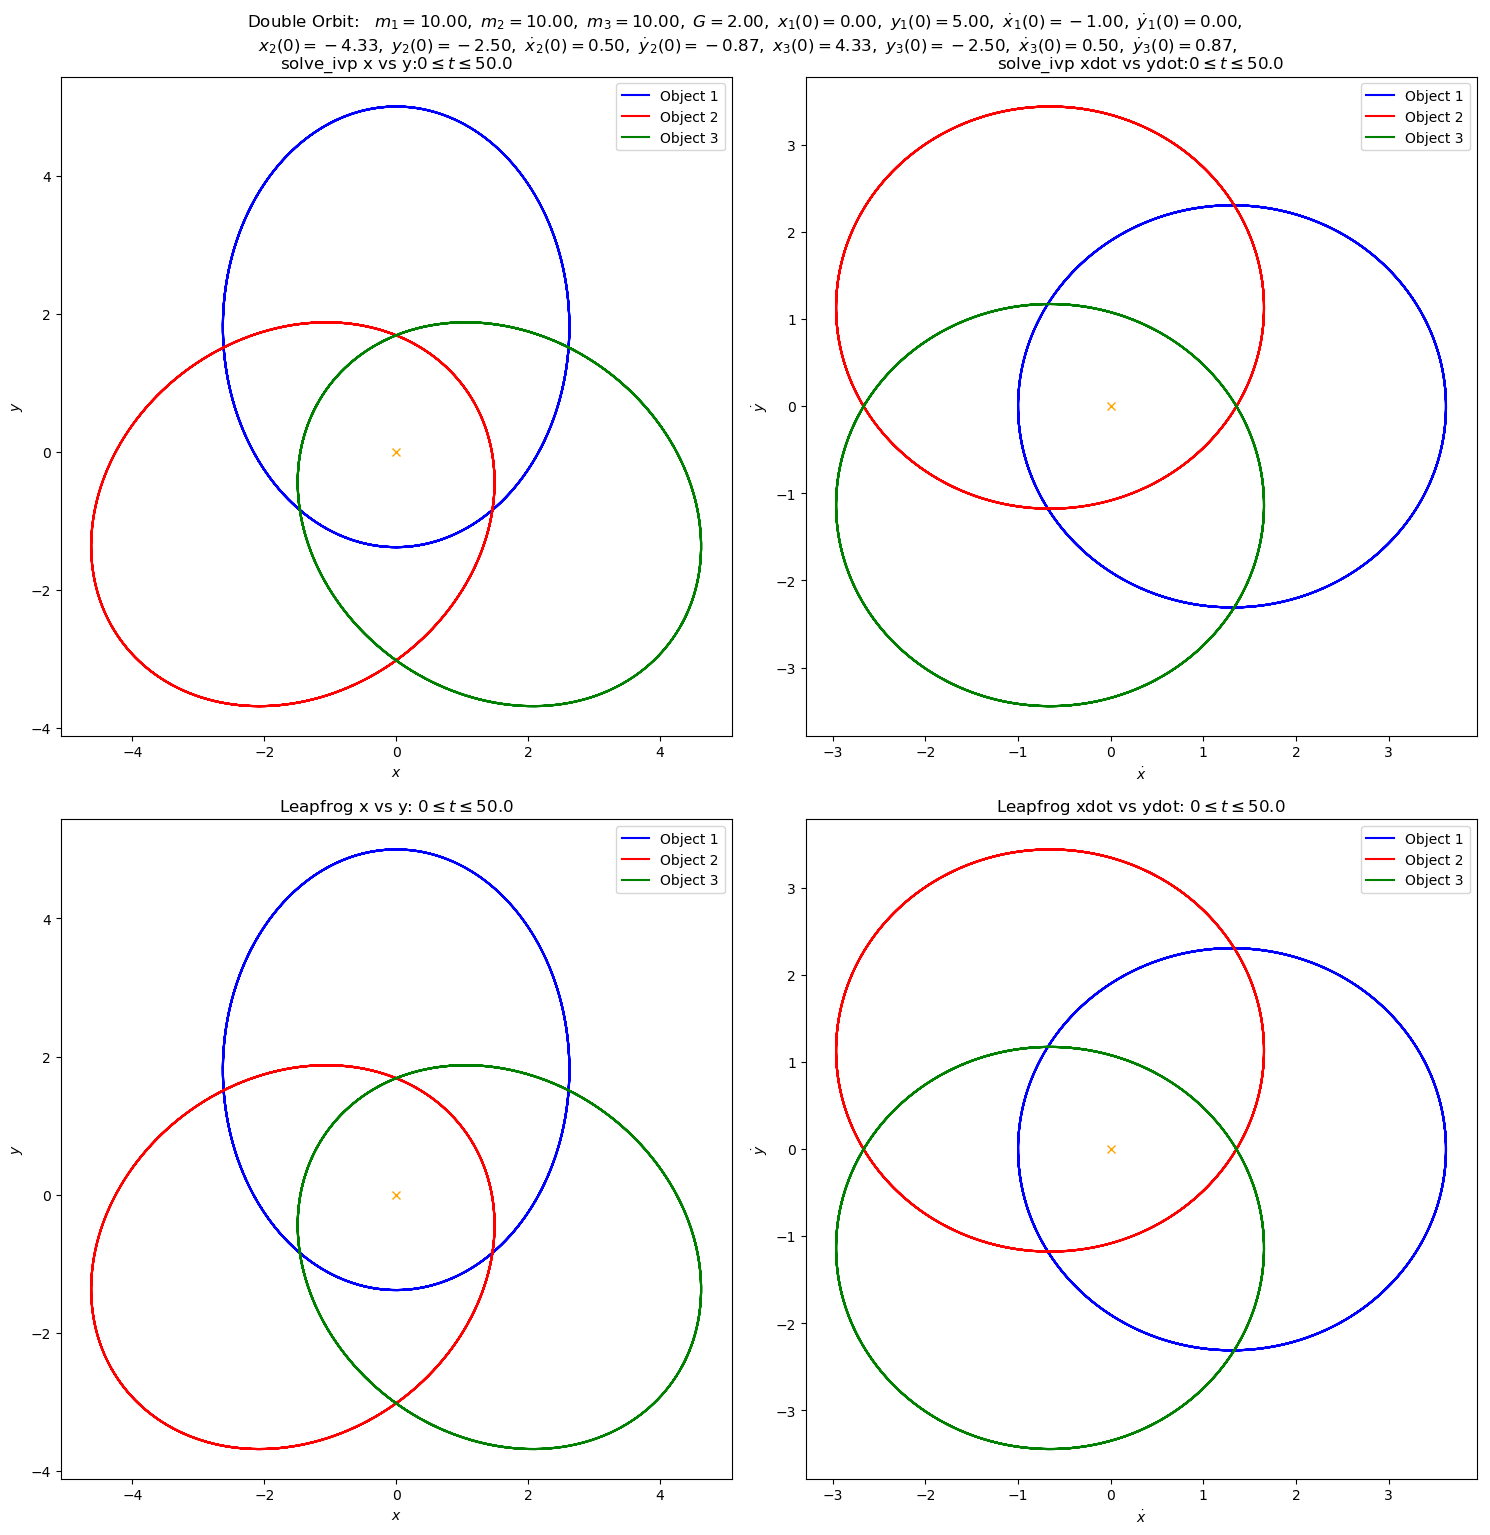

In [73]:
# Setup IC for Diff. Eq. Solvers
y_0 =[x1_0, y1_0, x2_0, y2_0, x3_0, y3_0, x1_dot_0, y1_dot_0, x2_dot_0, \
        y2_dot_0, x3_dot_0, y3_dot_0]
# Solve differential equations and store in variables using:
# solve_ivp
x1, y1, x2, y2, x3, y3, x1_dot, y1_dot, x2_dot, y2_dot, x3_dot, y3_dot \
    = to1.solve_ode(t_pts, y_0)
# Leapfrog
x1_2, y1_2, x2_2, y2_2, x3_2, y3_2, x1_dot_2, y1_dot_2, x2_dot_2, y2_dot_2, \
    x3_dot_2, y3_dot_2 = to1.solve_ode_Leapfrog(t_pts, y_0)

# start the plot!
fig = plt.figure(figsize=(15,15))

overall_title_general = 'Double Orbit:  ' + \
                rf' $m_1 = {m_1:.2f},$' + \
                rf' $m_2 = {m_2:.2f},$' + \
                rf' $m_3 = {m_3:.2f},$' + \
                rf' $G = {G_val:.2f},$' + \
                rf' $x_1(0) = {x1_0:.2f},$' + \
                rf' $y_1(0) = {y1_0:.2f},$' + \
                rf' $\dot x_1(0) = {x1_dot_0:.2f},$'+ \
                rf' $\dot y_1(0) = {y1_dot_0:.2f},$' + '\n' \
                rf' $x_2(0) = {x2_0:.2f},$' + \
                rf' $y_2(0) = {y2_0:.2f},$' + \
                rf' $\dot x_2(0) = {x2_dot_0:.2f},$' + \
                rf' $\dot y_2(0) = {y2_dot_0:.2f},$' + \
                rf' $x_3(0) = {x3_0:.2f},$' + \
                rf' $y_3(0) = {y3_0:.2f},$' + \
                rf' $\dot x_3(0) = {x3_dot_0:.2f},$'+ \
                rf' $\dot y_3(0) = {y3_dot_0:.2f},$'+'\n'
fig.suptitle(overall_title_general, va='baseline')

# first plot position: plot from t=0 to t=10   
ax_a = fig.add_subplot(2,2,1)

# Add an 'x' at the CM of two objects (if using CalcStationaryIC)
ax_a.plot([0], [0], 'x', c='orange')

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x1[start : stop], y1[start : stop], 
            color='blue',
            label="Object 1",
            ax=ax_a)
plot_y_vs_x(x2[start : stop], y2[start : stop], 
            color='red',
            label="Object 2",
            ax=ax_a)
plot_y_vs_x(x3[start : stop], y3[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='green',
            label="Object 3", 
            title=rf'solve_ivp x vs y:$0 \leq t \leq {t_end:.1f}$', 
            ax=ax_a)  

# second plot: state space plot from t=30 to t=50   
ax_b = fig.add_subplot(2,2,2)                  
ax_b.plot([0], [0], 'x', c='orange')
start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x1_dot[start : stop], y1_dot[start : stop], 
            color='blue',
            label="Object 1",
            ax=ax_b)  
plot_y_vs_x(x2_dot[start : stop], y2_dot[start : stop], 
            color='red',
            label="Object 2",
            ax=ax_b) 
plot_y_vs_x(x3_dot[start : stop], y3_dot[start : stop], 
            axis_labels=deltax_vs_deltay, 
            color='green',
            label="Object 3", 
            title=rf'solve_ivp xdot vs ydot:$0 \leq t \leq {t_end:.1f}$', 
            ax=ax_b)  


# first plot position: plot from t=0 to t=10   
ax_a = fig.add_subplot(2,2,3)                  
ax_a.plot([0], [0], 'x', c='orange')
start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x1_2[start : stop], y1_2[start : stop], 
            color='blue',
            label="Object 1",
            ax=ax_a) 
plot_y_vs_x(x2_2[start : stop], y2_2[start : stop], 
            color='red',
            label="Object 2",
            ax=ax_a) 
plot_y_vs_x(x3_2[start : stop], y3_2[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='green',
            label="Object 3", 
            title=rf'Leapfrog x vs y: $0 \leq t \leq {t_end:.1f}$', 
            ax=ax_a)  

# second plot: state space plot from t=30 to t=50   
ax_b = fig.add_subplot(2,2,4)                  
ax_b.plot([0], [0], 'x', c='orange')
start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(x1_dot_2[start : stop], y1_dot_2[start : stop], 
            color='blue',
            label="Object 1",
            ax=ax_b)  
plot_y_vs_x(x2_dot_2[start : stop], y2_dot_2[start : stop], 
            color='red',
            label="Object 2",
            ax=ax_b)  
plot_y_vs_x(x3_dot_2[start : stop], y3_dot_2[start : stop], 
            axis_labels=deltax_vs_deltay, 
            color='green',
            label="Object 3", 
            title=rf'Leapfrog xdot vs ydot: $0 \leq t \leq {t_end:.1f}$', 
            ax=ax_b)

fig.tight_layout()
fig.savefig('TripleOrbit.png', bbox_inches='tight')  # always bbox_inches='tight'